1. Período de análisis solicitado: 2020-01-01 a 2021-12-31
   Tasa de conversión: 1 EUR = 4000 COP

2. Procesando datos de Colombia
  Colombia OK. Meses procesados: 22.

3. Procesando datos de Noruega
  Noruega OK. Meses procesados: 16.

4. Procesando datos de Alemania/Francia
  Alemania/Francia OK. Meses procesados: 14.

5. Procesando datos del Nivel Agregado de Embalses
  Embalses OK. Meses procesados: 24.

6. Preparando Modelo de Predicción de Precios (ML)

  Resultados de la Regresión Lineal:
  RMSE: 9.41 COP/kWh | R^2: 0.4924

7. Consolidando series en fechas comunes

Correlación Precio Spot vs. Nivel Embalse: -0.7037

8. Generando 6 Gráficas en el orden solicitado


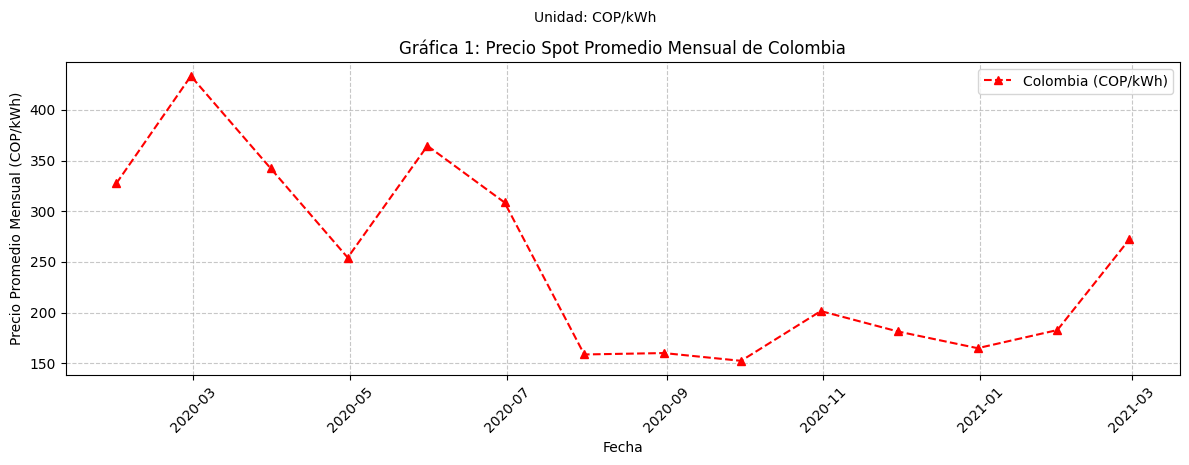

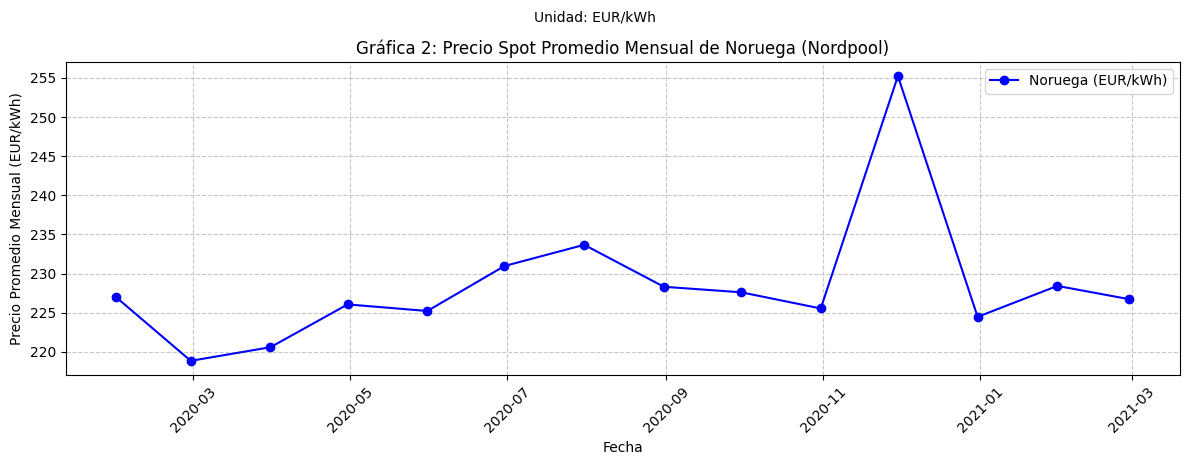

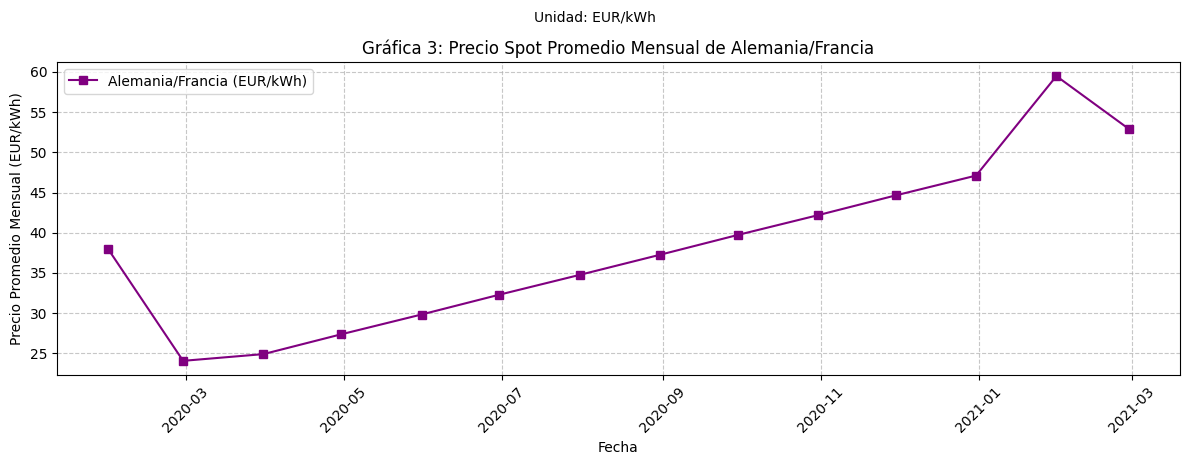

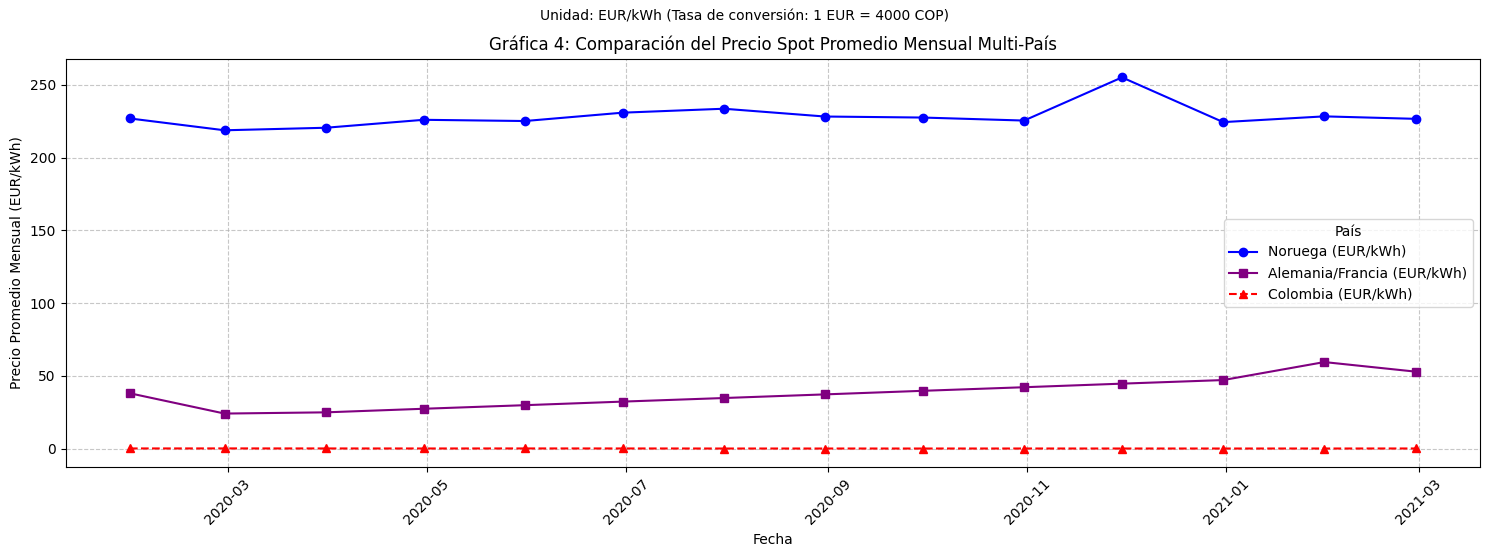

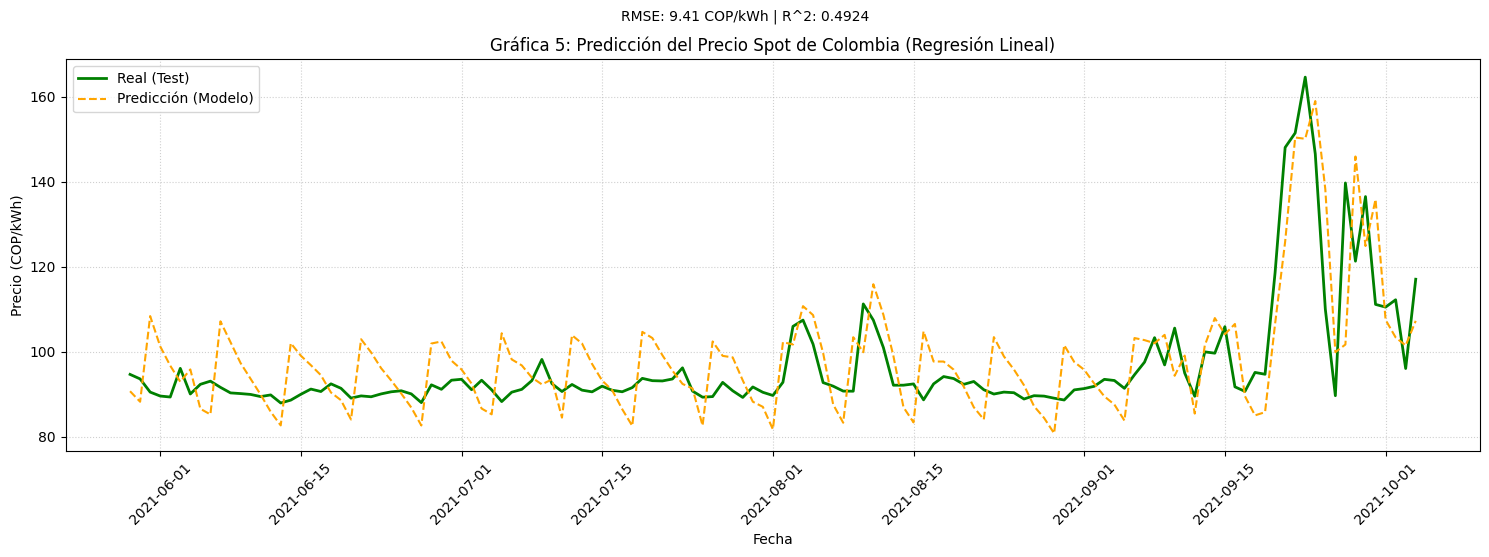

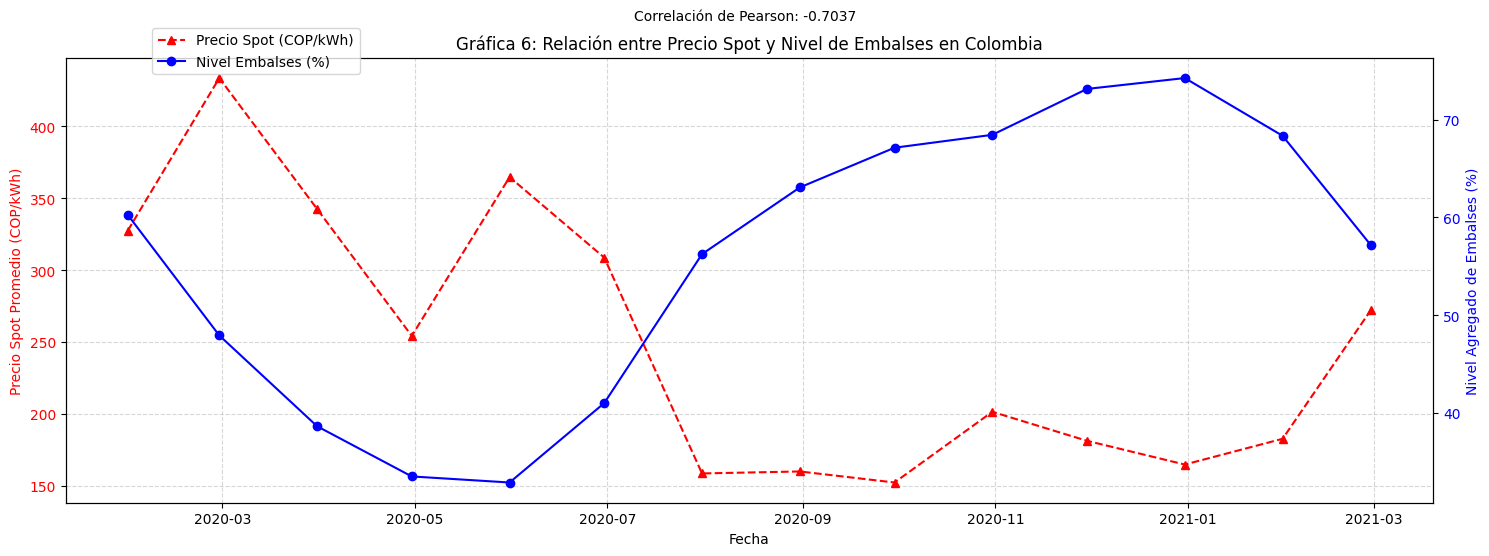

In [ ]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import unicodedata
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Configuración de Parámetros y APIs
ANIO_INICIO = '2020-01-01'
ANIO_FIN = '2021-12-31'
TASA_CAMBIO_COP_POR_EUR = 4000

# APIs para obtener datos
NORDPOOL_API = "https://sheetdb.io/api/v1/thma2z0rowstm"
COLOMBIA_API = "https://api.sheety.co/88787cbd1a8fa2c4c990e0a0e44a6475/preciodebolsaponderadoColombia/preciodebolsaponderadoacda7E04137D49049C5CF56Ae063390FCsv"
EMBALSES_API = "https://sheetdb.io/api/v1/cqwmh3juhhsdr"
ALEMANIA_FRANCIA_API = "https://api.sheety.co/88787cbd1a8fa2c4c990e0a0e44a6475/alemaniaOFrancia/alemaniaOFrancia"

# Series de datos mensuales a inicializar
df_eu_monthly_eur = pd.Series(dtype='float64') # Precio de Noruega
df_co_monthly_cop = pd.Series(dtype='float64') # Precio de Colombia
df_embalses_monthly_pct = pd.Series(dtype='float64') # Nivel de Embalses
df_de_fr_monthly_eur = pd.Series(dtype='float64') # Precio Alemania/Francia

# Nombres de columna base para manejo de datos
DATE_COL_CO = 'fecha'
VALUE_COL_CO = 'valor'
DATE_EMBALSE_COL = 'Fecha'
REGION_EMBALSE_COL = 'Embalse'
VOLUME_COL_EXACT = 'Volumen_Util_Energia_GWh'
CAPACITY_COL_EXACT = 'Capacidad_Util_Energia_GWh'
VALUE_EMBALSE_COL = 'Nivel_Embalse_Porcentaje'

# Función para limpiar nombres de columnas
def clean_col_name_strict(name):
    # Quita acentos, espacios y caracteres especiales, convierte a minúsculas.
    name = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8')
    name = name.replace(' ', '_').replace('-', '_')
    name = re.sub(r'[^a-zA-Z0-9_]', '', name)
    return name.lower()

print(f"1. Período de análisis solicitado: {ANIO_INICIO} a {ANIO_FIN}")
print(f"   Tasa de conversión: 1 EUR = {TASA_CAMBIO_COP_POR_EUR} COP")


# Procesar datos de Colombia (COP/kWh)
print("\n2. Procesando datos de Colombia")
try:
    response_co = requests.get(COLOMBIA_API, timeout=30)
    response_co.raise_for_status()

    # Cargar y limpiar el DataFrame
    data_json = response_co.json()
    if isinstance(data_json, dict) and data_json:
        data_list = data_json.get(list(data_json.keys())[0], [])
        df_co_raw = pd.DataFrame(data_list)
    else:
        df_co_raw = pd.DataFrame(data_json)

    df_co_raw.columns = df_co_raw.columns.str.lower()
    df_co_raw.rename(columns={'fecha': DATE_COL_CO, 'valor': VALUE_COL_CO}, inplace=True)

    # Convertir a formato de fecha y número
    df_co_raw[DATE_COL_CO] = pd.to_datetime(df_co_raw[DATE_COL_CO], errors='coerce')
    df_co_raw[VALUE_COL_CO] = pd.to_numeric(
        df_co_raw[VALUE_COL_CO].astype(str).str.replace(',', '.', regex=False), errors='coerce'
    ).astype(float)

    df_co_raw.dropna(subset=[DATE_COL_CO, VALUE_COL_CO], inplace=True)

    # Calcular el promedio diario y filtrar por el período
    df_co_diario = df_co_raw.set_index(DATE_COL_CO).sort_index()
    df_co_diario = df_co_diario[[VALUE_COL_CO]].resample('D').mean()
    df_co_diario = df_co_diario.loc[ANIO_INICIO:ANIO_FIN].dropna().copy()

    # Calcular el promedio mensual para la gráfica
    df_co_monthly_cop = df_co_diario[VALUE_COL_CO].resample('ME').mean()
    print(f"  Colombia OK. Meses procesados: {len(df_co_monthly_cop)}.")

except Exception as e:
    print(f"  Error al procesar datos de Colombia: {e}")
    df_co_monthly_cop = pd.Series(dtype='float64')
    df_co_diario = pd.DataFrame()


# Procesar datos de Noruega (EUR/kWh)
print("\n3. Procesando datos de Noruega")
try:
    response_eu = requests.get(NORDPOOL_API, timeout=30)
    response_eu.raise_for_status()

    df_eu = pd.DataFrame(response_eu.json())

    # Limpieza, conversión de tipos y filtrado
    df_eu['SpotPriceEUR'] = pd.to_numeric(df_eu['SpotPriceEUR'].astype(str).str.replace(',', '.', regex=False), errors='coerce')
    df_eu['HourUTC'] = pd.to_datetime(df_eu['HourUTC'])
    df_eu = df_eu.set_index('HourUTC').sort_index()

    df_eu_filtrado = df_eu.loc[ANIO_INICIO:ANIO_FIN, 'SpotPriceEUR'].copy()
    df_eu_filtrado = df_eu_filtrado.fillna(df_eu_filtrado.mean())

    # Calcular el promedio mensual
    df_eu_monthly_eur = df_eu_filtrado.resample('ME').mean()

    print(f"  Noruega OK. Meses procesados: {len(df_eu_monthly_eur)}.")

except Exception as e:
    print(f"  Error al procesar datos de Noruega: {e}")
    df_eu_monthly_eur = pd.Series(dtype='float64')


# Procesar datos de Alemania/Francia (EUR/kWh)
print("\n4. Procesando datos de Alemania/Francia")
try:
    response_de_fr = requests.get(ALEMANIA_FRANCIA_API, timeout=30)
    response_de_fr.raise_for_status()

    data_json_de_fr = response_de_fr.json()

    # Cargar y normalizar el DataFrame
    if isinstance(data_json_de_fr, dict) and data_json_de_fr:
        data_list_de_fr = data_json_de_fr.get(list(data_json_de_fr.keys())[0], [])
        df_de_fr_raw = pd.DataFrame(data_list_de_fr)
    else:
        df_de_fr_raw = pd.DataFrame(data_json_de_fr)

    # Asegurar nombres de columnas correctos
    if df_de_fr_raw.shape[1] == 2:
        df_de_fr_raw.columns = [DATE_COL_CO, VALUE_COL_CO]
    else:
        df_de_fr_raw.columns = df_de_fr_raw.columns.str.lower()
        if DATE_COL_CO not in df_de_fr_raw.columns:
            date_col_match = [col for col in df_de_fr_raw.columns if 'fecha' in col or 'date' in col]
            if date_col_match:
                df_de_fr_raw.rename(columns={date_col_match[0]: DATE_COL_CO}, inplace=True)
        if VALUE_COL_CO not in df_de_fr_raw.columns:
            value_col_match = [col for col in df_de_fr_raw.columns if 'valor' in col or 'precio' in col or 'price' in col]
            if value_col_match:
                df_de_fr_raw.rename(columns={value_col_match[0]: VALUE_COL_CO}, inplace=True)


    df_de_fr_raw[DATE_COL_CO] = pd.to_datetime(df_de_fr_raw[DATE_COL_CO], errors='coerce')
    df_de_fr_raw[VALUE_COL_CO] = pd.to_numeric(
        df_de_fr_raw[VALUE_COL_CO].astype(str).str.replace(',', '.', regex=False), errors='coerce'
    ).astype(float)

    df_de_fr_diario = df_de_fr_raw.dropna(subset=[DATE_COL_CO, VALUE_COL_CO]).set_index(DATE_COL_CO).sort_index()
    df_de_fr_diario = df_de_fr_diario[[VALUE_COL_CO]].resample('D').mean()
    df_de_fr_diario = df_de_fr_diario.loc[ANIO_INICIO:ANIO_FIN].copy()

    # Se aplica interpolación lineal para rellenar vacíos
    df_de_fr_diario[VALUE_COL_CO] = df_de_fr_diario[VALUE_COL_CO].interpolate(method='linear')

    # Calcular el promedio mensual
    df_de_fr_monthly_eur = df_de_fr_diario[VALUE_COL_CO].resample('ME').mean().dropna()

    print(f"  Alemania/Francia OK. Meses procesados: {len(df_de_fr_monthly_eur)}.")

except Exception as e:
    print(f"  Error al procesar datos de Alemania/Francia: {e}")
    df_de_fr_monthly_eur = pd.Series(dtype='float64')

# Procesar datos de Embalses (Nivel %)
print("\n5. Procesando datos del Nivel Agregado de Embalses")
try:
    response_emb = requests.get(EMBALSES_API, timeout=30)
    response_emb.raise_for_status()

    df_emb = pd.DataFrame(response_emb.json())
    df_emb.columns = [clean_col_name_strict(col) for col in df_emb.columns]

    date_col = clean_col_name_strict(DATE_EMBALSE_COL)
    volumen_col = clean_col_name_strict(VOLUME_COL_EXACT)
    capacidad_col = clean_col_name_strict(CAPACITY_COL_EXACT)

    # Conversión de tipos y filtrado por fecha
    df_emb[date_col] = pd.to_datetime(df_emb[date_col], errors='coerce')
    df_emb[volumen_col] = pd.to_numeric(df_emb[volumen_col], errors='coerce')
    df_emb[capacidad_col] = pd.to_numeric(df_emb[capacidad_col], errors='coerce')
    df_emb.dropna(subset=[date_col, volumen_col, capacidad_col], inplace=True)

    start_date = pd.to_datetime(ANIO_INICIO)
    end_date = pd.to_datetime(ANIO_FIN)

    df_filtrado_fechas = df_emb.loc[
        (df_emb[date_col].dt.normalize() >= start_date) &
        (df_emb[date_col].dt.normalize() <= end_date)
    ].copy()

    # Agrupar por día para calcular el nivel agregado (%)
    df_emb_diario = df_filtrado_fechas.groupby(df_filtrado_fechas[date_col].dt.normalize()).agg(
        Total_Volumen=(volumen_col, 'sum'),
        Total_Capacidad=(capacidad_col, 'sum')
    )

    df_emb_diario[VALUE_EMBALSE_COL] = (
        df_emb_diario['Total_Volumen'] / df_emb_diario['Total_Capacidad']
    ) * 100
    df_emb_diario.index.name = DATE_COL_CO

    # Calcular el promedio mensual para la gráfica
    df_embalses_monthly_pct = df_emb_diario[VALUE_EMBALSE_COL].resample('ME').mean()

    if len(df_embalses_monthly_pct) == 0:
        raise ValueError(f"No hay datos de embalses en el rango de fechas.")

    print(f"  Embalses OK. Meses procesados: {len(df_embalses_monthly_pct)}.")

except Exception as e:
    print(f"  Error al procesar datos de Embalses: {e}")
    df_embalses_monthly_pct = pd.Series(dtype='float64')
    df_emb_diario = pd.DataFrame()


# Modelo de Predicción (Machine Learning)
print("\n6. Preparando Modelo de Predicción de Precios (ML)")

try:
    if df_co_diario.empty or df_emb_diario.empty:
        raise ValueError("Datos de Colombia o Embalses vacíos. No se puede entrenar el modelo.")

    # Fusionar Precio Spot de Colombia y Nivel de Embalses
    df_ml = df_co_diario.rename(columns={VALUE_COL_CO: 'Precio_COP'}).copy()
    df_ml = df_ml.merge(
        df_emb_diario[[VALUE_EMBALSE_COL]],
        left_index=True,
        right_index=True,
        how='inner'
    )

    # Crear características de tiempo (Mes, Día_Semana) y rezagos (Precio_Ayer, Embalse_Ayer)
    df_ml['Mes'] = df_ml.index.month
    df_ml['Dia_Semana'] = df_ml.index.dayofweek
    df_ml['Precio_Ayer'] = df_ml['Precio_COP'].shift(1)
    df_ml['Embalse_Ayer'] = df_ml[VALUE_EMBALSE_COL].shift(1)
    df_ml.dropna(inplace=True)

    if df_ml.empty:
        raise ValueError("El dataset ML está vacío después de crear features.")

    # Definir variables de entrenamiento (X) y objetivo (Y)
    X = df_ml[['Precio_Ayer', 'Embalse_Ayer', 'Mes', 'Dia_Semana']]
    Y = df_ml['Precio_COP']

    # Dividir datos para entrenamiento (80%) y prueba (20%)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

    # Entrenar la Regresión Lineal
    model = LinearRegression()
    model.fit(X_train, Y_train)

    # Evaluar el modelo
    Y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)

    print(f"\n  Resultados de la Regresión Lineal:")
    print(f"  RMSE: {rmse:.2f} COP/kWh | R^2: {r2:.4f}")

except Exception as e:
    print(f"  Error al ejecutar el Modelo de Predicción: {e}")
    Y_test = pd.Series(dtype='float64')
    Y_pred = np.array([])
    rmse = np.nan
    r2 = np.nan


# Ajuste de Datos para Gráficas
# Se convierte el precio de Colombia a EUR/kWh para la comparación internacional
df_co_monthly_eur = df_co_monthly_cop / TASA_CAMBIO_COP_POR_EUR

if df_co_monthly_cop.empty or df_eu_monthly_eur.empty or df_embalses_monthly_pct.empty or df_de_fr_monthly_eur.empty:
    print("\nError: No se puede graficar. Una o más series están vacías.")
    fechas_comunes = pd.Index([])
else:
    print("\n7. Consolidando series en fechas comunes")

    # Encontrar la intersección de fechas disponibles en todas las series
    fechas_comunes = df_co_monthly_eur.index.intersection(df_eu_monthly_eur.index).intersection(df_de_fr_monthly_eur.index).intersection(df_embalses_monthly_pct.index)

    if len(fechas_comunes) == 0:
          print(f"No se encontraron fechas comunes entre las series.")
    else:
        # Ajustar todas las series a las fechas comunes
        df_co_monthly_eur_ajustado = df_co_monthly_eur.loc[fechas_comunes]
        df_eu_monthly_eur_ajustado = df_eu_monthly_eur.loc[fechas_comunes]
        df_de_fr_monthly_eur_ajustado = df_de_fr_monthly_eur.loc[fechas_comunes]
        df_co_monthly_cop_ajustado = df_co_monthly_cop.loc[fechas_comunes]
        df_embalses_monthly_pct_ajustado = df_embalses_monthly_pct.loc[fechas_comunes]


# Preparación de DataFrames para Gráficas
if len(fechas_comunes) > 0:

    # DataFrame para Gráfica 4 (Comparación Multi-país)
    df_comparison = pd.DataFrame({
        'Noruega (Nordpool)': df_eu_monthly_eur_ajustado,
        'Alemania/Francia': df_de_fr_monthly_eur_ajustado,
        'Colombia (Convertido)': df_co_monthly_eur_ajustado
    }).dropna()

    # DataFrame para Gráfica 6 (Relación Precio vs Embalses)
    df_relacion = pd.DataFrame({
        'Precio_Spot_COP': df_co_monthly_cop_ajustado,
        'Nivel_Embalse_Pct': df_embalses_monthly_pct_ajustado
    }).dropna()

    # Cálculo de la Correlación para Gráfica 6
    correlacion = df_relacion['Precio_Spot_COP'].corr(df_relacion['Nivel_Embalse_Pct'])
    print(f"\nCorrelación Precio Spot vs. Nivel Embalse: {correlacion:.4f}")


# Generación de Gráficas en el Orden Solicitado
print("\n8. Generando 6 Gráficas en el orden solicitado")

if len(fechas_comunes) > 0:

    # Gráfica 1: Precio Spot Mensual de Colombia (COP/kWh)
    plt.figure(figsize=(12, 5))
    plt.plot(df_co_monthly_cop_ajustado.index, df_co_monthly_cop_ajustado, label='Colombia (COP/kWh)', marker='^', linestyle='--', color='red')
    plt.title('Gráfica 1: Precio Spot Promedio Mensual de Colombia')
    plt.suptitle(f'Unidad: COP/kWh', fontsize=10, y=0.92)
    plt.xlabel('Fecha')
    plt.ylabel('Precio Promedio Mensual (COP/kWh)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Gráfica 2: Precio Spot Mensual de Noruega (EUR/kWh)
    plt.figure(figsize=(12, 5))
    plt.plot(df_eu_monthly_eur_ajustado.index, df_eu_monthly_eur_ajustado.values,
             label='Noruega (EUR/kWh)', marker='o', linestyle='-', color='blue')
    plt.title('Gráfica 2: Precio Spot Promedio Mensual de Noruega (Nordpool)')
    plt.suptitle(f'Unidad: EUR/kWh', fontsize=10, y=0.92)
    plt.xlabel('Fecha')
    plt.ylabel('Precio Promedio Mensual (EUR/kWh)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Gráfica 3: Precio Spot Mensual de Alemania/Francia (EUR/kWh)
    plt.figure(figsize=(12, 5))
    plt.plot(df_de_fr_monthly_eur_ajustado.index, df_de_fr_monthly_eur_ajustado.values,
             label='Alemania/Francia (EUR/kWh)', marker='s', linestyle='-', color='purple')
    plt.title('Gráfica 3: Precio Spot Promedio Mensual de Alemania/Francia')
    plt.suptitle(f'Unidad: EUR/kWh', fontsize=10, y=0.92)
    plt.xlabel('Fecha')
    plt.ylabel('Precio Promedio Mensual (EUR/kWh)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Gráfica 4: Comparación Multi-País (EUR/kWh)
    plt.figure(figsize=(15, 6))

    plt.plot(df_comparison.index, df_comparison['Noruega (Nordpool)'], label='Noruega (EUR/kWh)', marker='o', linestyle='-', color='blue')
    plt.plot(df_comparison.index, df_comparison['Alemania/Francia'], label='Alemania/Francia (EUR/kWh)', marker='s', linestyle='-', color='purple')
    plt.plot(df_comparison.index, df_comparison['Colombia (Convertido)'], label='Colombia (EUR/kWh)', marker='^', linestyle='--', color='red')

    plt.title(f'Gráfica 4: Comparación del Precio Spot Promedio Mensual Multi-País')
    plt.suptitle(f'Unidad: EUR/kWh (Tasa de conversión: 1 EUR = {TASA_CAMBIO_COP_POR_EUR} COP)', fontsize=10, y=0.92)
    plt.xlabel('Fecha')
    plt.ylabel('Precio Promedio Mensual (EUR/kWh)')
    plt.legend(title='País')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Las siguientes gráficas dependen del éxito del modelo ML
if not Y_test.empty and not df_relacion.empty:

    # Gráfica 5: Predicción ML (COP/kWh)
    plt.figure(figsize=(15, 6))
    plt.plot(Y_test.index, Y_test, label='Real (Test)', color='green', linewidth=2)
    plt.plot(Y_test.index, Y_pred, label='Predicción (Modelo)', color='orange', linestyle='--')
    plt.title('Gráfica 5: Predicción del Precio Spot de Colombia (Regresión Lineal)')
    plt.suptitle(f'RMSE: {rmse:.2f} COP/kWh | R^2: {r2:.4f}', fontsize=10, y=0.92)
    plt.xlabel('Fecha')
    plt.ylabel('Precio (COP/kWh)')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Gráfica 6: Relación Precio vs. Embalses (Doble Eje Y)
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Eje Y1 para Precio Spot
    color = 'red'
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Precio Spot Promedio (COP/kWh)', color=color)
    ax1.plot(df_relacion.index, df_relacion['Precio_Spot_COP'], color=color, label='Precio Spot (COP/kWh)', marker='^', linestyle='--')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Eje Y2 para Nivel de Embalse
    ax2 = ax1.twinx()
    color = 'blue'
    ax2.set_ylabel('Nivel Agregado de Embalses (%)', color=color)
    ax2.plot(df_relacion.index, df_relacion['Nivel_Embalse_Pct'], color=color, label='Nivel Embalses (%)', marker='o', linestyle='-')
    ax2.tick_params(axis='y', labelcolor=color)

    # Título y Leyenda
    plt.title('Gráfica 6: Relación entre Precio Spot y Nivel de Embalses en Colombia')
    plt.suptitle(f'Correlación de Pearson: {correlacion:.4f}', fontsize=10, y=0.92)
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    print("\nADVERTENCIA: Las gráficas de Predicción ML y Relación Embalses no se pudieron generar por falta de datos o errores en el modelo.")